# **Import the libraries**

In [177]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [178]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [179]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import string
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

# **Loading the training data**

In [180]:
df_train = pd.read_csv("/content/train.tsv",sep="\t",header = None)
df_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [181]:
#Provide column names
columns = ["ID", "Label", "Statement", "Subject", "Speaker", "Speaker Job Title",
    "State Info", "Party Affiliation", "Barely True Counts", "False Counts",
    "Half True Counts", "Mostly True Counts", "Pants on Fire Counts", "Context"]
df_train = pd.read_csv("/content/train.tsv",sep="\t",header = None, names = columns)
df_train.head()

,ID,Label,Statement,Subject,Speaker,Speaker Job Title,State Info,Party Affiliation,Barely True Counts,False Counts,Half True Counts,Mostly True Counts,Pants on Fire Counts,Context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


# **Looking for missing values**

In [182]:
# Ignoring the large number of missing values as the required columns(Label and Statement doesnt have any)
df_train.isnull().sum()

,0
ID,0
Label,0
Statement,0
Subject,2
Speaker,2
Speaker Job Title,2898
State Info,2210
Party Affiliation,2
Barely True Counts,2
False Counts,2


# **Add binary target column: is_fake (1 = fake, 0 = real)**

In [183]:
false = ["false","pants-fire","barely-true"]
true = ["half-true","mostly-true","true"]
df_train["is_false"] =df_train["Label"].apply(lambda x : 1 if x in false else 0)
df_train.head()

,ID,Label,Statement,Subject,Speaker,Speaker Job Title,State Info,Party Affiliation,Barely True Counts,False Counts,Half True Counts,Mostly True Counts,Pants on Fire Counts,Context,is_false
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,1
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,0
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,0
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,1
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,0


# **Data Cleaning**

In [184]:
#Removing unnecessary columns
df_train = df_train.drop(['ID','Subject','Speaker','Speaker Job Title','State Info',	'Party Affiliation','Barely True Counts','False Counts','Half True Counts','Mostly True Counts','Pants on Fire Counts','Context'],axis=1)
df_train.head()

,Label,Statement,is_false
0,false,Says the Annies List political group supports ...,1
1,half-true,When did the decline of coal start? It started...,0
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",0
3,false,Health care reform legislation is likely to ma...,1
4,half-true,The economic turnaround started at the end of ...,0


In [185]:
#Removing duplicates
df_train = df_train.drop_duplicates(subset = ["Statement"])
df_train.head()

,Label,Statement,is_false
0,false,Says the Annies List political group supports ...,1
1,half-true,When did the decline of coal start? It started...,0
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",0
3,false,Health care reform legislation is likely to ma...,1
4,half-true,The economic turnaround started at the end of ...,0


# **Visualising Label counts**

In [186]:
#Getting the original label counts
label_counts_train=df_train['Label'].value_counts()
label_counts_train

,count
Label,
half-true,2109
false,1987
mostly-true,1961
true,1674
barely-true,1653
pants-fire,839


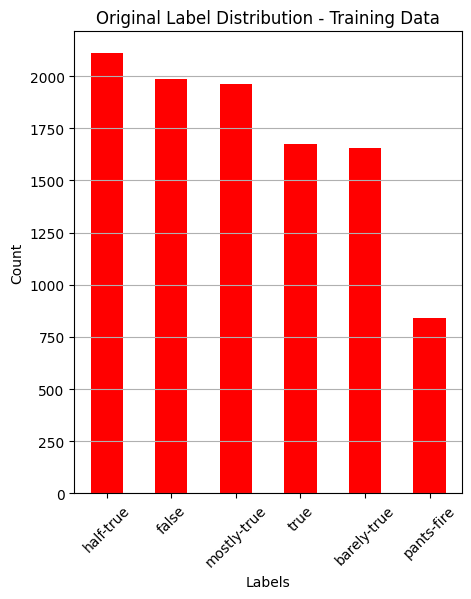

In [187]:
#Plotting label counts
plt.figure(figsize = (5,6))
label_counts_train.plot(kind = "bar",color="red")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.xticks(rotation = 45)
plt.grid(axis = 'y')
plt.title("Original Label Distribution - Training Data")
plt.show()


In [188]:
#Binary target counts
false_counts_train = df_train['is_false'].value_counts()
false_counts_train

,count
is_false,
0,5744
1,4479


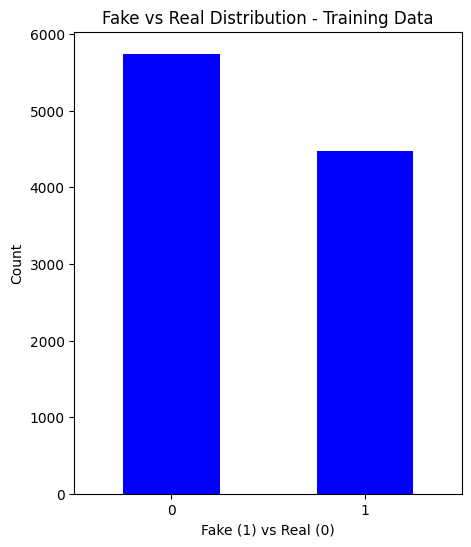

In [189]:
#Plotting
plt.figure(figsize=(5, 6))
false_counts_train.plot(kind="bar", color="blue")
plt.xlabel("Fake (1) vs Real (0)")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.title("Fake vs Real Distribution - Training Data")
plt.show()


# **Loading the validation data**

In [190]:
df_valid = pd.read_csv("/content/valid.tsv",sep ="\t",header = None,names = columns)
df_valid.head()

,ID,Label,Statement,Subject,Speaker,Speaker Job Title,State Info,Party Affiliation,Barely True Counts,False Counts,Half True Counts,Mostly True Counts,Pants on Fire Counts,Context
0,12134.json,barely-true,We have less Americans working now than in the...,"economy,jobs",vicky-hartzler,U.S. Representative,Missouri,republican,1,0,1,0,0,an interview with ABC17 News
1,238.json,pants-fire,"When Obama was sworn into office, he DID NOT u...","obama-birth-certificate,religion",chain-email,NaN,NaN,none,11,43,8,5,105,NaN
2,7891.json,false,Says Having organizations parading as being so...,"campaign-finance,congress,taxes",earl-blumenauer,U.S. representative,Oregon,democrat,0,1,1,1,0,a U.S. Ways and Means hearing
3,8169.json,half-true,Says nearly half of Oregons children are poor.,poverty,jim-francesconi,Member of the State Board of Higher Education,Oregon,none,0,1,1,1,0,an opinion article
4,929.json,half-true,On attacks by Republicans that various program...,"economy,stimulus",barack-obama,President,Illinois,democrat,70,71,160,163,9,interview with CBS News


In [191]:
false = ["false","pants-fire","barely-true"]
true = ["half-true","mostly-true","true"]
df_valid["is_false"] =df_valid["Label"].apply(lambda x : 1 if x in false else 0)
df_valid.head()

,ID,Label,Statement,Subject,Speaker,Speaker Job Title,State Info,Party Affiliation,Barely True Counts,False Counts,Half True Counts,Mostly True Counts,Pants on Fire Counts,Context,is_false
0,12134.json,barely-true,We have less Americans working now than in the...,"economy,jobs",vicky-hartzler,U.S. Representative,Missouri,republican,1,0,1,0,0,an interview with ABC17 News,1
1,238.json,pants-fire,"When Obama was sworn into office, he DID NOT u...","obama-birth-certificate,religion",chain-email,NaN,NaN,none,11,43,8,5,105,NaN,1
2,7891.json,false,Says Having organizations parading as being so...,"campaign-finance,congress,taxes",earl-blumenauer,U.S. representative,Oregon,democrat,0,1,1,1,0,a U.S. Ways and Means hearing,1
3,8169.json,half-true,Says nearly half of Oregons children are poor.,poverty,jim-francesconi,Member of the State Board of Higher Education,Oregon,none,0,1,1,1,0,an opinion article,0
4,929.json,half-true,On attacks by Republicans that various program...,"economy,stimulus",barack-obama,President,Illinois,democrat,70,71,160,163,9,interview with CBS News,0


In [192]:
df_valid = df_valid.drop(['ID','Subject','Speaker','Speaker Job Title','State Info',	'Party Affiliation','Barely True Counts','False Counts','Half True Counts','Mostly True Counts','Pants on Fire Counts','Context'],axis = 1)
df_valid.head()

,Label,Statement,is_false
0,barely-true,We have less Americans working now than in the...,1
1,pants-fire,"When Obama was sworn into office, he DID NOT u...",1
2,false,Says Having organizations parading as being so...,1
3,half-true,Says nearly half of Oregons children are poor.,0
4,half-true,On attacks by Republicans that various program...,0


In [193]:
label_counts_valid=df_valid['Label'].value_counts()
label_counts_valid

,count
Label,
false,263
mostly-true,251
half-true,248
barely-true,237
true,169
pants-fire,116


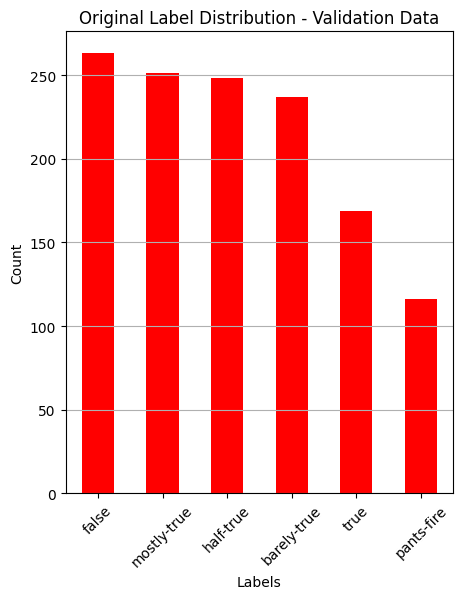

In [194]:
plt.figure(figsize = (5,6))
label_counts_valid.plot(kind = "bar",color="red")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.xticks(rotation = 45)
plt.grid(axis = 'y')
plt.title("Original Label Distribution - Validation Data")
plt.show()

In [195]:
false_counts_valid = df_valid['is_false'].value_counts()
false_counts_valid

,count
is_false,
0,668
1,616


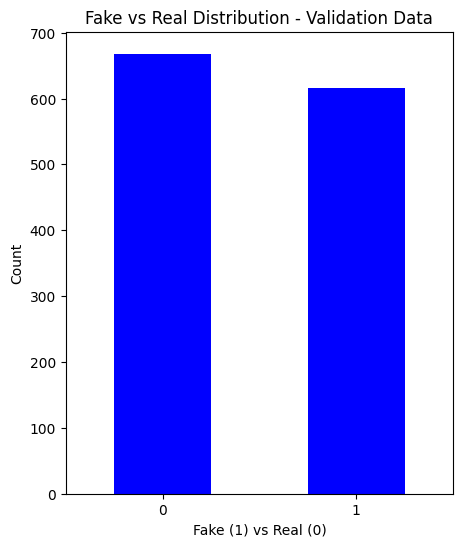

In [196]:
plt.figure(figsize=(5, 6))
false_counts_valid.plot(kind="bar", color="blue")
plt.xlabel("Fake (1) vs Real (0)")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.title("Fake vs Real Distribution - Validation Data")
plt.show()

# **Loading the test data**

In [197]:
df_test = pd.read_csv("/content/test.tsv",sep ="\t",header = None,names = columns)
df_test.head()

,ID,Label,Statement,Subject,Speaker,Speaker Job Title,State Info,Party Affiliation,Barely True Counts,False Counts,Half True Counts,Mostly True Counts,Pants on Fire Counts,Context
0,11972.json,true,Building a wall on the U.S.-Mexico border will...,immigration,rick-perry,Governor,Texas,republican,30,30,42,23,18,Radio interview
1,11685.json,false,Wisconsin is on pace to double the number of l...,jobs,katrina-shankland,State representative,Wisconsin,democrat,2,1,0,0,0,a news conference
2,11096.json,false,Says John McCain has done nothing to help the ...,"military,veterans,voting-record",donald-trump,President-Elect,New York,republican,63,114,51,37,61,comments on ABC's This Week.
3,5209.json,half-true,Suzanne Bonamici supports a plan that will cut...,"medicare,message-machine-2012,campaign-adverti...",rob-cornilles,consultant,Oregon,republican,1,1,3,1,1,a radio show
4,9524.json,pants-fire,When asked by a reporter whether hes at the ce...,"campaign-finance,legal-issues,campaign-adverti...",state-democratic-party-wisconsin,NaN,Wisconsin,democrat,5,7,2,2,7,a web video


In [198]:
false = ["false","pants-fire","barely-true"]
true = ["half-true","mostly-true","true"]
df_test["is_false"] =df_test["Label"].apply(lambda x : 1 if x in false else 0)
df_test.head()

,ID,Label,Statement,Subject,Speaker,Speaker Job Title,State Info,Party Affiliation,Barely True Counts,False Counts,Half True Counts,Mostly True Counts,Pants on Fire Counts,Context,is_false
0,11972.json,true,Building a wall on the U.S.-Mexico border will...,immigration,rick-perry,Governor,Texas,republican,30,30,42,23,18,Radio interview,0
1,11685.json,false,Wisconsin is on pace to double the number of l...,jobs,katrina-shankland,State representative,Wisconsin,democrat,2,1,0,0,0,a news conference,1
2,11096.json,false,Says John McCain has done nothing to help the ...,"military,veterans,voting-record",donald-trump,President-Elect,New York,republican,63,114,51,37,61,comments on ABC's This Week.,1
3,5209.json,half-true,Suzanne Bonamici supports a plan that will cut...,"medicare,message-machine-2012,campaign-adverti...",rob-cornilles,consultant,Oregon,republican,1,1,3,1,1,a radio show,0
4,9524.json,pants-fire,When asked by a reporter whether hes at the ce...,"campaign-finance,legal-issues,campaign-adverti...",state-democratic-party-wisconsin,NaN,Wisconsin,democrat,5,7,2,2,7,a web video,1


In [199]:
df_test = df_test.drop(['ID','Subject','Speaker','Speaker Job Title','State Info',	'Party Affiliation','Barely True Counts','False Counts','Half True Counts','Mostly True Counts','Pants on Fire Counts','Context'],axis = 1)
df_test.head()

,Label,Statement,is_false
0,true,Building a wall on the U.S.-Mexico border will...,0
1,false,Wisconsin is on pace to double the number of l...,1
2,false,Says John McCain has done nothing to help the ...,1
3,half-true,Suzanne Bonamici supports a plan that will cut...,0
4,pants-fire,When asked by a reporter whether hes at the ce...,1


In [200]:
label_counts_test=df_test['Label'].value_counts()
label_counts_test

,count
Label,
half-true,265
false,249
mostly-true,241
barely-true,212
true,208
pants-fire,92


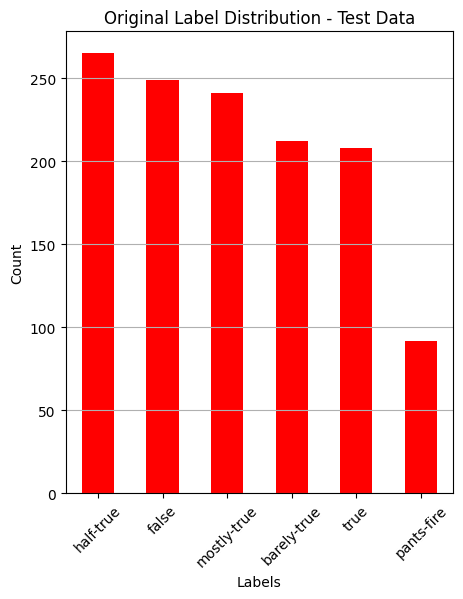

In [201]:
plt.figure(figsize = (5,6))
label_counts_test.plot(kind = "bar",color="red")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.xticks(rotation = 45)
plt.grid(axis = 'y')
plt.title("Original Label Distribution - Test Data")
plt.show()

In [202]:
false_counts_test = df_test['is_false'].value_counts()
false_counts_test

,count
is_false,
0,714
1,553


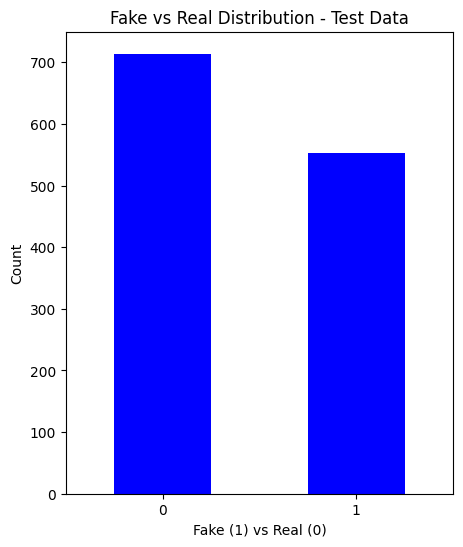

In [203]:
plt.figure(figsize=(5, 6))
false_counts_test.plot(kind="bar", color="blue")
plt.xlabel("Fake (1) vs Real (0)")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.title("Fake vs Real Distribution - Test Data")
plt.show()

# **Text Preprocessing**


In [204]:
#lemmatizer = WordNetLemmatizer()
#stop_words = set(stopwords.words('english'))

#def clean_lemmatize(text):
    # Lowercase
    #text = text.lower()
    # Remove urls, html, punctuation, digits
    #text = re.sub(r'https?://\S+|www\.\S+|<.*?>+|\n|[^a-zA-Z\s]', '', text)
    # Tokenize
    #tokens = text.split()
    # Lemmatize + remove stopwords
    #tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    # Rejoin
    #return ' '.join(tokens)

# Apply to train & test
#df_train['Statement'] = df_train['Statement'].apply(clean_lemmatize)
#df_test['Statement'] = df_test['Statement'].apply(clean_lemmatize)
#df_valid['Statement'] = df_valid['Statement'].apply(clean_lemmatize)

In [205]:
#Lowercasing
df_train['Statement'] = df_train['Statement'].str.lower()
df_valid['Statement'] = df_valid['Statement'].str.lower()
df_test['Statement'] = df_test['Statement'].str.lower()

In [206]:
#Tf-Idf vectorization
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
x_train = vectorizer.fit_transform(df_train['Statement'])
x_valid = vectorizer.transform(df_valid['Statement'])

In [207]:
y_train = df_train['is_false']
y_valid = df_valid['is_false']

In [208]:
print(x_train.shape)
print(x_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(10223, 10000)
(1284, 10000)
(10223,)
(1284,)


In [209]:
x_test = vectorizer.transform(df_test['Statement'])
y_test = df_test['is_false']
print(x_test.shape)
print(y_test.shape)

(1267, 10000)
(1267,)


# **Model Training - Logistic Regression**

In [210]:
#Model Training
lr = LogisticRegression(C= 2.0)
lr.fit(x_train,y_train)

LogisticRegression(C=2.0)

# **Evaluation of Validation Set**

In [211]:
y_valid_pred = lr.predict(x_valid)

In [212]:
target_names = ['Real','Fake']

In [213]:
print("Validation Accuracy:", accuracy_score(y_valid, y_valid_pred))
print("Validation Report:\n", classification_report(y_valid.values, y_valid_pred, target_names=target_names))

Validation Accuracy: 0.6246105919003115
Validation Report:
               precision    recall  f1-score   support

        Real       0.62      0.72      0.67       668
        Fake       0.63      0.52      0.57       616

    accuracy                           0.62      1284
   macro avg       0.63      0.62      0.62      1284
weighted avg       0.63      0.62      0.62      1284



# **Model Evaluation**

In [214]:
y_pred = lr.predict(x_test)

In [215]:
print("Accuracy score",accuracy_score(y_test,y_pred))
print("Classification report",classification_report(y_test.values,y_pred,target_names = target_names))
print("Confusion matrix",confusion_matrix(y_test,y_pred))

Accuracy score 0.6227308602999211
Classification report               precision    recall  f1-score   support

        Real       0.64      0.75      0.69       714
        Fake       0.59      0.46      0.52       553

    accuracy                           0.62      1267
   macro avg       0.61      0.60      0.60      1267
weighted avg       0.62      0.62      0.61      1267

Confusion matrix [[533 181]
 [297 256]]


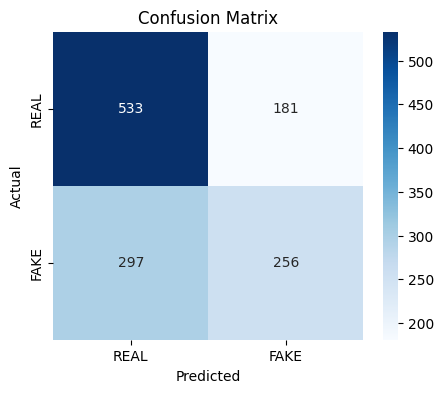

In [216]:
#Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['REAL', 'FAKE'], yticklabels=['REAL', 'FAKE'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# **Model Evaluation-SVM**

In [217]:
from sklearn.svm import LinearSVC
svm = LinearSVC(C = 1.0)
svm.fit(x_train,y_train)
y_valid_pred_svm = svm.predict(x_valid)
print("SVM Validation Accuracy:", accuracy_score(y_valid, y_valid_pred_svm))
print("SVM Validation Report:")
print(classification_report(y_valid, y_valid_pred_svm, target_names = target_names))

SVM Validation Accuracy: 0.5926791277258567
SVM Validation Report:
              precision    recall  f1-score   support

        Real       0.60      0.65      0.62       668
        Fake       0.58      0.53      0.55       616

    accuracy                           0.59      1284
   macro avg       0.59      0.59      0.59      1284
weighted avg       0.59      0.59      0.59      1284



In [218]:
y_pred = svm.predict(x_test)
print("Accuracy score",accuracy_score(y_test,y_pred))
print("Classification report",classification_report(y_test.values,y_pred,target_names = target_names))
print("Confusion matrix",confusion_matrix(y_test,y_pred))

Accuracy score 0.611681136543015
Classification report               precision    recall  f1-score   support

        Real       0.64      0.69      0.67       714
        Fake       0.56      0.51      0.53       553

    accuracy                           0.61      1267
   macro avg       0.60      0.60      0.60      1267
weighted avg       0.61      0.61      0.61      1267

Confusion matrix [[495 219]
 [273 280]]


# **Sample Manual Testing**

In [219]:
sample_text = "Government approves new fake currency notes to tackle inflation"
sample_text = sample_text.lower()
sample_vector = vectorizer.transform([sample_text])
sample_pred = lr.predict(sample_vector)[0]

if sample_pred == 1:
    print("Prediction: FAKE news")
else:
    print("Prediction: REAL news")


Prediction: FAKE news
